In [1]:
import pandas as pd
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.__version__

'1.9.1.post3'

In [2]:
democrats = pd.read_parquet("../10_datasets/democrats")
republicans = pd.read_parquet("../10_datasets/neutral.parquet")
neutral = pd.read_parquet("../10_datasets/republican.parquet")

In [3]:
democrats.shape

(4937, 7)

In [4]:
republicans["subreddit"].value_counts()

NeutralPolitics    4760
Name: subreddit, dtype: int64

In [5]:
df = pd.concat([democrats, republicans, neutral])

In [7]:
df.head()

,id,total_post,subreddit,score,type,title,text
index,,,,,,,
2818,ggh2x3s,Putin and the Russian oligarchy are the money ...,democrats,6.0,comment,None,None
49047,ftfbnpa,"Don't worry, the conservatived would never do ...",democrats,4.0,comment,None,None
28276,g5rlhoy,RIP an amazing judge who accomplished a lot ov...,democrats,5.0,comment,None,None
8614,gd1798c,Trump and his legion during the opening of the...,democrats,8.0,comment,None,None
40142,fyruoz3,The eventual goal is election policing to try ...,democrats,9.0,comment,None,None


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["subreddit"])
df['encoded_subreddit'] = le.transform(df['subreddit'])

In [9]:
df['encoded_subreddit'].value_counts()

2    282
1    248
0      5
Name: encoded_subreddit, dtype: int64

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    df['total_post'], df['encoded_subreddit'], test_size=.2, stratify=df['subreddit'], random_state=42)

In [11]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(428,) (107,) (428,) (107,)


In [12]:
vectorizer = TfidfVectorizer(lowercase=True)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)


In [13]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(x_test)).float()

In [14]:
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [15]:
model = nn.Sequential(nn.Linear(x_train.shape[1], 64),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(64, df['subreddit'].nunique()),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Forward pass, get our logits
logps = model(x_train)
# Calculate the loss with the logits and the labels
loss = criterion(logps, y_train)

loss.backward()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [16]:
%%time
train_losses = []
test_losses = []
test_accuracies = []

epochs = 50
for e in range(epochs):
    optimizer.zero_grad()

    output = model.forward(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    optimizer.step()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_ps = model(x_test)
        test_loss = criterion(log_ps, y_test)
        test_losses.append(test_loss)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y_test.view(*top_class.shape)
        test_accuracy = torch.mean(equals.float())
        test_accuracies.append(test_accuracy)

    model.train()

    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {train_loss:.3f}.. ",
          f"Test Loss: {test_loss:.3f}.. ",
          f"Test Accuracy: {test_accuracy:.3f}")

Epoch: 1/50..  Training Loss: 1.071..  Test Loss: 1.062..  Test Accuracy: 0.607
Epoch: 2/50..  Training Loss: 1.057..  Test Loss: 1.051..  Test Accuracy: 0.654
Epoch: 3/50..  Training Loss: 1.042..  Test Loss: 1.040..  Test Accuracy: 0.682
Epoch: 4/50..  Training Loss: 1.025..  Test Loss: 1.028..  Test Accuracy: 0.682
Epoch: 5/50..  Training Loss: 1.006..  Test Loss: 1.015..  Test Accuracy: 0.701
Epoch: 6/50..  Training Loss: 0.986..  Test Loss: 1.002..  Test Accuracy: 0.701
Epoch: 7/50..  Training Loss: 0.967..  Test Loss: 0.989..  Test Accuracy: 0.701
Epoch: 8/50..  Training Loss: 0.945..  Test Loss: 0.975..  Test Accuracy: 0.701
Epoch: 9/50..  Training Loss: 0.922..  Test Loss: 0.962..  Test Accuracy: 0.701
Epoch: 10/50..  Training Loss: 0.898..  Test Loss: 0.948..  Test Accuracy: 0.701
Epoch: 11/50..  Training Loss: 0.874..  Test Loss: 0.934..  Test Accuracy: 0.701
Epoch: 12/50..  Training Loss: 0.850..  Test Loss: 0.919..  Test Accuracy: 0.692
Epoch: 13/50..  Training Loss: 0.825.

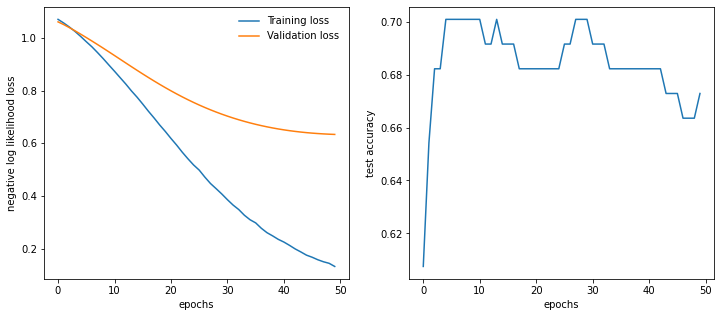

In [17]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('negative log likelihood loss')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(test_accuracies);